# Comparing PCA and factor analysis

In [69]:
# Import libraries
from IPython.display import Markdown as md
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.decomposition import FactorAnalysis


Let's start with a vessel at constant volume $ V $ and temperature $ T $, which we are filling with $ n $ moles of an ideal gas. We measure the pressure $ P $ and the mass of the gas, $ m $. However, we know the following relationships holds:

$$ P = \left( \frac{RT}{V} \right) n $$

$$ m = Mn $$

Where $ R $ is the universal gas constant and $ M $ is the molar mass of the gas. Let us imagine we took $ N = 1000 $ different measurements of $ m $ and $ P $. The measurements aren't perfectly accurate, so we add some measurement noise.

Text(0, 0.5, 'Pressure (kPa)')

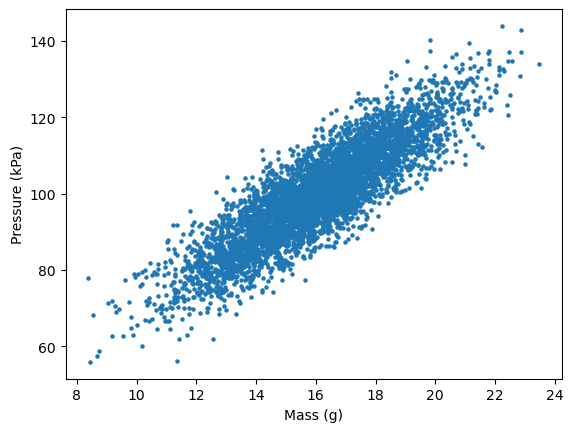

In [70]:
R = 8.314   # J/(mol K), ideal gas constant
T = 300     # K, temperature
V = 0.1     # m^3, volume
M = 4       # g/mol, molar mass of He
N = 5000

# Generate the true values of molar amount n, mass m, and pressure p
rng = np.random.default_rng(2)
n = rng.normal(4, 0.5, N)   # mol
m = n*M             # g
P = R*T*n/V / 1000  # kPa

# We measured the mass and the pressure, but the measurements have some errors
measured_m = m + rng.normal(0, 1, N)  # g
measured_P = P + rng.normal(0, 2.5, N)  # kPa

# Plot the measured values
plt.scatter(measured_m, measured_P, s = 5)
plt.xlabel('Mass (g)')
plt.ylabel('Pressure (kPa)')

Factor analysis assumes a model of the form

$$ \mathbf{x} = F \mathbf{h}  + \mathbf{ε} $$

In this model, $ \mathbf{x} ∈ \mathbb{R}^p $ represents our observed values and $ \mathbf{h} $ represents the unobserved hidden factors.

c:\Users\tmlouw\Anaconda3\envs\py3_11\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0, 0.5, 'ε2')

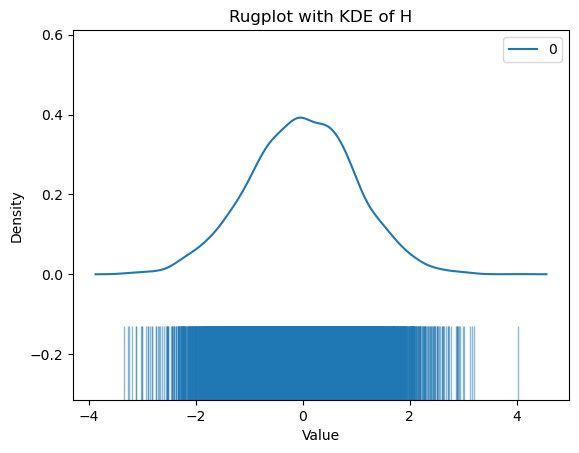

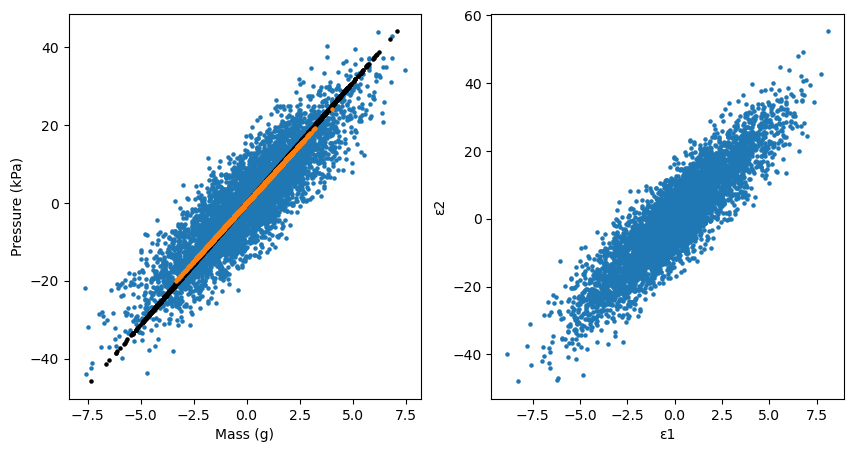

In [71]:
# Form the data matrix X
X = np.concatenate((measured_m.reshape(-1,1), measured_P.reshape(-1,1)), axis = 1)
X = X - np.mean(X, axis = 0)

F = np.array([[1],[6]])
#H = np.linspace(-1, 1, N).reshape(-1,1)
H = rng.normal(0, 1,N ).reshape(-1,1)
HF = H @ F.T
ε = X - HF

# Create the rugplot with KDE
sns.rugplot(data=H, height=0.2, color='blue', alpha=0.5)
sns.kdeplot(data=H)

# Set plot labels and title
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Rugplot with KDE of H')

fix, ax = plt.subplots(1, 2, figsize = (10, 5))

# Show the plot
ax[0].scatter(X[:,0], X[:,1], s = 5)
ax[0].scatter(m - np.mean(m), P - np.mean(P), c = 'k', s = 5)
ax[0].scatter(HF[:,0],HF[:,1], s = 5)
ax[0].set_xlabel('Mass (g)')
ax[0].set_ylabel('Pressure (kPa)')

ax[1].scatter(ε[:,0], ε[:,1], s = 5)
ax[1].set_xlabel('ε1')
ax[1].set_ylabel('ε2')  


[[1.14555541 0.        ]
 [0.         1.00340858]]
[[ 1.12248669 -0.15010908]
 [-0.15010908  0.02666005]]
[[ 1.12225202 -0.15014   ]
 [-0.15014     0.02625748]]


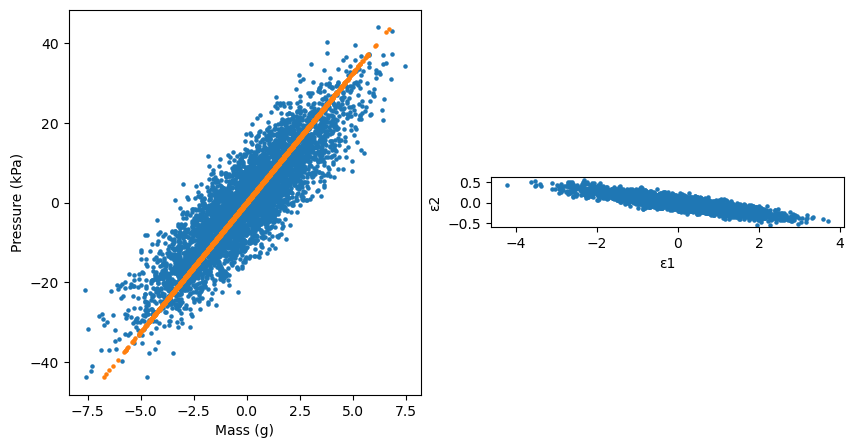

In [78]:
# Form the data matrix X
X = np.concatenate((measured_m.reshape(-1,1), measured_P.reshape(-1,1)), axis = 1)
X = X - np.mean(X, axis = 0)

FA = FactorAnalysis(n_components=1, tol = 1e-6, max_iter=  5000)
FA.fit(X)
F = FA.components_
Ψ = np.array([[FA.noise_variance_[0], 0], [0, FA.noise_variance_[1]]])

#C = np.linalg.inv(F.T @ F + Ψ)
C = np.linalg.inv(np.cov(X.T))
H = ( F @ C @ X.T ).T # Equivalent to H = FA.transform(X)
HF = H @ F
ε = X - HF


fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].scatter(X[:,0], X[:,1], s = 5)
#ax[0].scatter(m - np.mean(m), P - np.mean(P), c = 'k', s = 5)
ax[0].scatter(HF[:,0],HF[:,1], s = 5)
ax[0].set_xlabel('Mass (g)')
ax[0].set_ylabel('Pressure (kPa)')

ax[1].scatter(ε[:,0], ε[:,1], s = 5)
ax[1].set_xlabel('ε1')
ax[1].set_ylabel('ε2')  
ax[1].set_aspect('equal')

print(Ψ)
print(ε.T @ ε / N )
print(Ψ @ C @ Ψ)

# In my opinion, the error covariance should be:
#  Ψ - Ψ @ C @ Ψ
# But instead, it is
#  Ψ @ C @ Ψ
# Why?

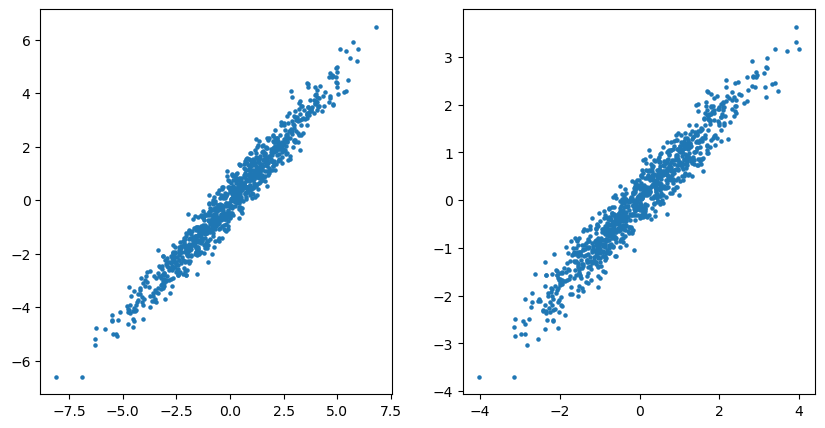

In [16]:
# Parity plots
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].scatter(X[:,0], HF[:,0], s = 5)
ax[1].scatter(X[:,1], HF[:,1], s = 5)
#ax[0].scatter(m - np.mean(m), HF[:,0], s = 5)
#ax[1].scatter(P - np.mean(P), HF[:,1], s = 5)


c:\Users\tmlouw\Anaconda3\envs\py3_11\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0.5, 1.0, 'Rugplot with KDE of H')

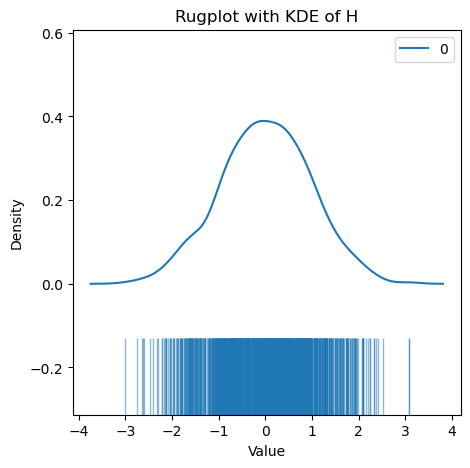

In [17]:
# Create the rugplot with KDE
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sns.rugplot(data=H, height=0.2, color='blue', alpha=0.5)
sns.kdeplot(data=H)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Rugplot with KDE of H')

Generate PVT data for an ideal gas

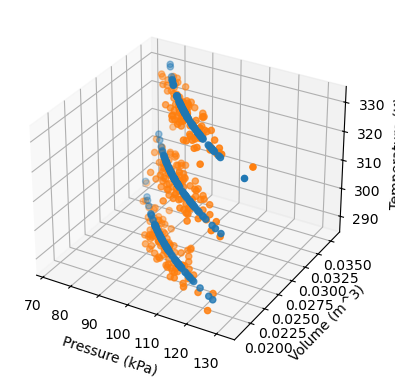

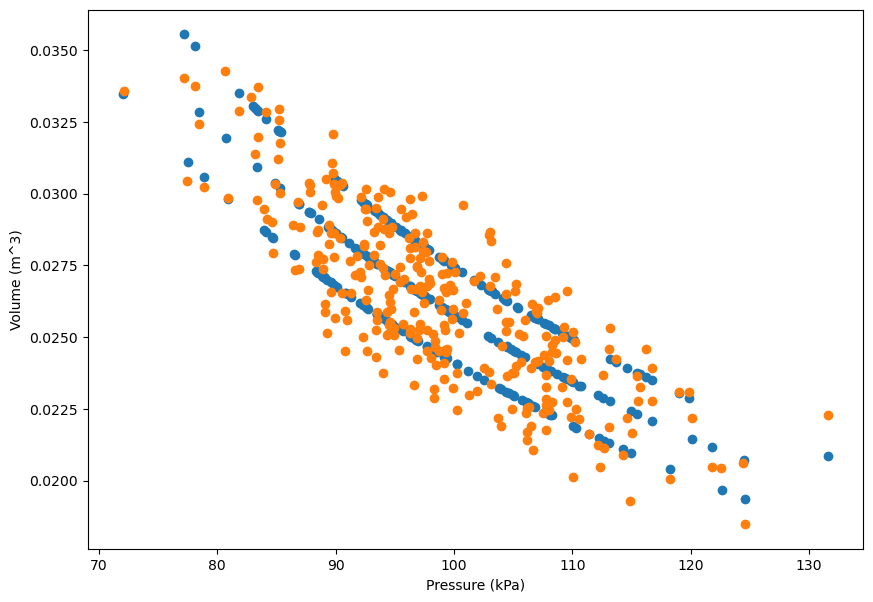

In [79]:
n = 100
N = 3*n     # Number of samples
R = 8.314   # Ideal gas constant
P = 1e5 + np.random.normal(0, 1e4, N)     # Pressure in Pa

# Temperature in K
T = np.ones_like(P)
T[:n] = 290    
T[n:2*n] = 310
T[2*n:] = 330 

V = R*T/P   # Volume in m^3
P = P/1000  # Pressure in kPa

mT = T + np.random.normal(0, 1, N)
mP = P + np.random.normal(0, 0.05, N)
mV = V + np.random.normal(0, 0.001, N)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(121, projection='3d')
ax.scatter3D(P, V, T)
ax.scatter3D(mP, mV, mT)
ax.set_xlabel('Pressure (kPa)')
ax.set_ylabel('Volume (m^3)')
ax.set_zlabel('Temperature (K)')
plt.show()

fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(P, V)
ax.scatter(mP, mV)
ax.set_xlabel('Pressure (kPa)')
ax.set_ylabel('Volume (m^3)')
plt.show()

